In [1]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
from scipy.stats import chisquare

import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]
from sklearn.preprocessing import StandardScaler

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]
cust_palette=sns.color_palette("Set2",2)


Autosaving every 120 seconds


In [2]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("data.xlsx"))
df.head()

,Response ID,c,PRE1,PRE2,PRE3,PRE4,PRE1_gender,PRE2_gender,PRE3_gender,PRE4_gender,...,Hire4_choice,"To what degree do you agree with the following statements: - People should be treated equally, regardless of their gender.",To what degree do you agree with the following statements: - In many important jobs it is better to contract men than women.,To what degree do you agree with the following statements: - We should stop thinking about whether people are men or women and focus on other characteristics.,Gender,Age,Race,Ide,Party,Edu
0,R_bkL4Dz6BWrpkuqt,1,a wigmaker,a cloth dealer,a candle maker,a dockworker,1,1,1,0,...,0,97,35,88,Female,44,American Indian or Alaska Native,100,Democrat,College Degree
1,R_qw7R6WE8ndNAjcJ,1,a potter,a wool inspector,a candle maker,a jeweler,1,0,1,1,...,1,100,42,44,Female,30,Black or African American,42,Other,High School Diploma
2,R_ac95CEDFNzCdFuN,1,a stonecutter,a cloth dealer,a candle maker,a jeweler,0,0,0,0,...,0,99,45,100,Female,53,White,51,Independent,Some College
3,R_248IFKeYRx8hz3f,1,a wigmaker,a cloth dealer,a candle maker,a jeweler,1,1,0,0,...,0,75,94,96,Male,26,White,92,Democrat,College Degree
4,R_3mgh8enf9nPQZmN,1,a shoe maker,a cloth dealer,a candle maker,a fish trapper,1,0,0,0,...,1,51,84,82,Female,23,White,2,Republican,High School Diploma


In [3]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
participant = df.loc[:,"Response ID"]

# Extract data with df.loc[:,"datastart":"dataend"]
PRE_male = df.loc[:, "PRE1_gender":"PRE2_gender"]
PRE_female = df.loc[:, "PRE3_gender":"PRE4_gender"]

POST_male = df.loc[:, "POST1_gender":"POST2_gender"]
POST_female = df.loc[:, "POST3_gender":"POST4_gender"]

POST_male_salary = df.loc[:, "POST1_salary":"POST2_salary"]
POST_female_salary = df.loc[:, "POST3_salary":"POST4_salary"]

POST_male_friendly = df.loc[:, "POST1_friendly":"POST2_friendly"]
POST_female_friendly = df.loc[:, "POST3_friendly":"POST4_friendly"]

POST_male_intelligent = df.loc[:, "POST1_intelligent":"POST2_intelligent"]
POST_female_intelligent = df.loc[:, "POST3_intelligent":"POST4_intelligent"]

Hire_m = df.loc[:, "Hire1_gender":"Hire2_gender"]
Hire_f = df.loc[:, "Hire3_gender":"Hire4_gender"]

Choice_m = df.loc[:, "Hire1_choice":"Hire2_choice"]
Choice_f = df.loc[:, "Hire3_choice":"Hire4_choice"]


# Item categories
Age = np.array(df.loc[:, "Age"])[:, np.newaxis]
Gender = np.array(df.loc[:, "Gender"])[:, np.newaxis]
Ide = np.array(df.loc[:, "Ide"])[:, np.newaxis]
Political = np.array(df.loc[:, "Party"])[:, np.newaxis]
Edu = np.array(df.loc[:, "Edu"])[:, np.newaxis]

sz = PRE_male.shape
partnum = np.arange(sz[0])[:, np.newaxis]
itemnum = np.arange(sz[-1])[np.newaxis, :]

# Make all the participant X item variables the same size with numpy arrays broadcast function
names = ["PRE_male", "PRE_female", "POST_male", "POST_female", "POST_male_salary", "POST_female_salary", \
         "POST_male_friendly",'POST_female_friendly', "POST_male_intelligent", "POST_female_intelligent", \
         "Hire_m", "Hire_f", 'Choice_m', 'Choice_f', \
         "itemnum", "partnum", 'Gender', "Ide", "Political", "Edu"]
data_packed = np.broadcast_arrays(PRE_male, PRE_female, POST_male, POST_female, POST_male_salary, POST_female_salary, \
                                  POST_male_friendly, POST_female_friendly, POST_male_intelligent, POST_female_intelligent, \
                                  Hire_m, Hire_f, Choice_m, Choice_f, itemnum, partnum, Gender, Ide, Political, Edu)
data_unpacked = [np.reshape(a, -1) for a in data_packed]

DATA = pd.DataFrame.from_dict({n: d for (n,d) in zip(names, data_unpacked)})

DATA.head()

,PRE_male,PRE_female,POST_male,POST_female,POST_male_salary,POST_female_salary,POST_male_friendly,POST_female_friendly,POST_male_intelligent,POST_female_intelligent,Hire_m,Hire_f,Choice_m,Choice_f,itemnum,partnum,Gender,Ide,Political,Edu
0,1,1,1,1,57,88,95.0,73.0,90.0,92.0,1,1,1,1,0,0,Female,100,Democrat,College Degree
1,1,0,0,0,63,44,66.0,79.0,74.0,96.0,0,0,0,0,1,0,Female,100,Democrat,College Degree
2,1,1,1,1,16,21,34.0,32.0,17.0,34.0,1,1,1,1,0,1,Female,42,Other,High School Diploma
3,0,1,0,1,27,18,26.0,30.0,34.0,36.0,0,1,0,1,1,1,Female,42,Other,High School Diploma
4,0,0,0,1,53,44,76.0,90.0,73.0,85.0,0,1,1,1,0,2,Female,51,Independent,Some College


In [7]:
DATA.male = DATA.loc[DATA.Gender=="Male", :]
DATA.male.head(2)

,PRE_male,PRE_female,POST_male,POST_female,POST_male_salary,POST_female_salary,POST_male_friendly,POST_female_friendly,POST_male_intelligent,POST_female_intelligent,Hire_m,Hire_f,Choice_m,Choice_f,itemnum,partnum,Gender,Ide,Political,Edu
6,1,0,1,0,70,50,89.0,90.0,89.0,91.0,1,0,1,0,0,3,Male,92,Democrat,College Degree
7,1,0,1,0,67,66,96.0,93.0,92.0,91.0,1,0,1,0,1,3,Male,92,Democrat,College Degree


In [9]:
DATA.female = DATA.loc[DATA.Gender=="Female", :]
DATA.female.head(2)

,PRE_male,PRE_female,POST_male,POST_female,POST_male_salary,POST_female_salary,POST_male_friendly,POST_female_friendly,POST_male_intelligent,POST_female_intelligent,Hire_m,Hire_f,Choice_m,Choice_f,itemnum,partnum,Gender,Ide,Political,Edu
0,1,1,1,1,57,88,95.0,73.0,90.0,92.0,1,1,1,1,0,0,Female,100,Democrat,College Degree
1,1,0,0,0,63,44,66.0,79.0,74.0,96.0,0,0,0,0,1,0,Female,100,Democrat,College Degree


In [10]:
res = chisquare(np.bincount(DATA["PRE_female"]))
print("p = %.5f" % res.pvalue)
print("χ2 = %.2f" % res.statistic)
print("w = %.5f" % np.sqrt(res.statistic/df.size))

p = 0.00032
χ2 = 12.94
w = 0.04107


In [26]:
res = chisquare(np.bincount(DATA["PRE_male"]))
print("p = %.5f" % res.pvalue)
print("χ2 = %.2f" % res.statistic)
print("w = %.5f" % np.sqrt(res.statistic/df.size))

p = 0.00000
χ2 = 21.06
w = 0.03674


In [13]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("df.xlsx"))
df.head()

,Condition,TimePoint,PercentF,PercentM,POST_salary,POST_friendly,POST_intelligent,Hire,Choice,itemnum,partnum,Gender,Ide,Political,Edu
0,High Inequality,PRE,1,0,NaN,NaN,NaN,NaN,NaN,0,0,Female,100,Democrat,College Degree
1,High Inequality,PRE,1,0,NaN,NaN,NaN,NaN,NaN,1,0,Female,100,Democrat,College Degree
2,High Inequality,PRE,1,0,NaN,NaN,NaN,NaN,NaN,0,1,Female,42,Other,High School Diploma
3,High Inequality,PRE,0,1,NaN,NaN,NaN,NaN,NaN,1,1,Female,42,Other,High School Diploma
4,High Inequality,PRE,0,1,NaN,NaN,NaN,NaN,NaN,0,2,Female,51,Independent,Some College


In [14]:
df_pre = df.loc[df.TimePoint=="PRE", :]
df_pre.head(1)

,Condition,TimePoint,PercentF,PercentM,POST_salary,POST_friendly,POST_intelligent,Hire,Choice,itemnum,partnum,Gender,Ide,Political,Edu
0,High Inequality,PRE,1,0,NaN,NaN,NaN,NaN,NaN,0,0,Female,100,Democrat,College Degree


<IPython.core.display.Javascript object>


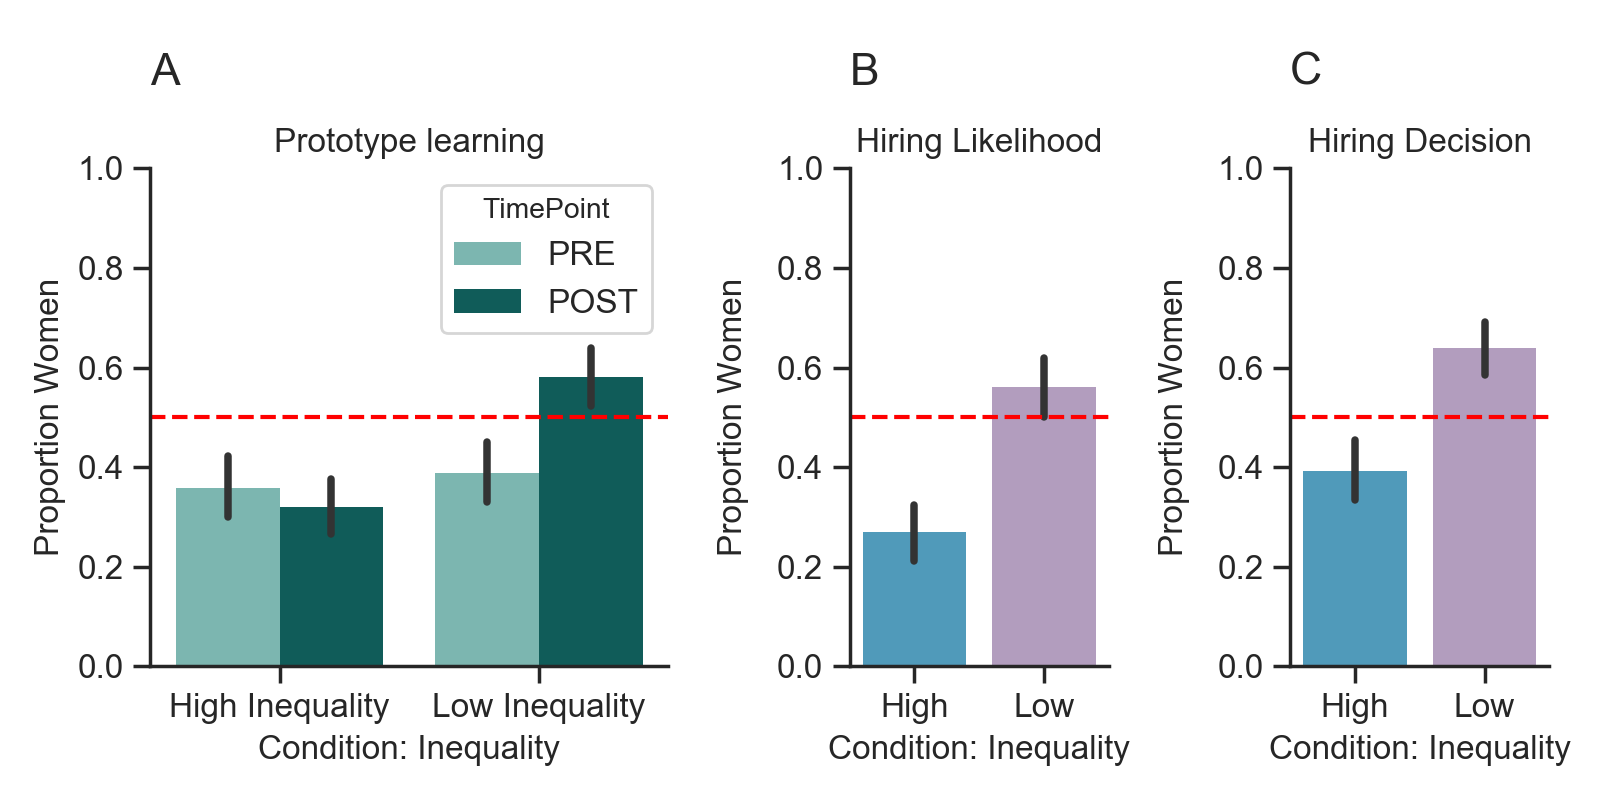

In [15]:
colors = ["#3EA1CC","#B497C4"]
colorspp = ["#72C0B7","#046865"]

fig, ax = plt.subplots(1,3, figsize=(8,4), gridspec_kw={"width_ratios": [2,1,1]})
sns.barplot(x='Condition', y="PercentF", hue='TimePoint', data=df, \
            palette=colorspp, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
ax[0].set_ylabel("Proportion Women")
ax[0].set_title("Prototype Learning")

sns.barplot(x='Condition', y='Hire', data=df, \
            palette=colors, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.barplot(x='Condition', y='Choice', data=df, \
            palette=colors, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2]) 
ax[0].set_ylim(0,1)
ax[1].set_ylim(0,1)

ax[1].set_ylabel("Proportion Women", labelpad=10)
ax[1].set_title("Hiring Likelihood")
ax[0].set_xlabel("Condition: Inequality")
ax[0].axhline(y=0.5, color='#FF0000', linestyle='--')
ax[1].axhline(y=0.5, color='#FF0000', linestyle='--')
ax[2].axhline(y=0.5, color='#FF0000', linestyle='--')

ax[1].set_xlabel("Condition: Inequality")
ax[1].set_xticklabels(["High",'Low'])
ax[2].set_xticklabels(["High",'Low'])

ax[2].set_ylabel("Proportion Women", labelpad=10)
ax[2].set_title("Hiring Choice")
ax[2].set_xlabel("Condition: Inequality")

bff.panellabel(ax[0], "A", title="Prototype learning")
bff.panellabel(ax[1], "B", title="Hiring Likelihood")
bff.panellabel(ax[2], "C", title="Hiring Decision")

plt.ylim(0,1)
sns.despine()
plt.tight_layout()

In [17]:
import warnings
warnings.filterwarnings('ignore')
8
%load_ext rpy2.ipython
# %R library(lme4)

%R library(lmerTest)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [ ]:
%Rpush df

In [33]:
%%R

M <- glmer(PercentM ~ as.factor(TimePoint)*as.factor(Condition) + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML ['lmerMod']
Formula: PercentM ~ as.factor(TimePoint) * as.factor(Condition) + (1 |  
    partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 1436.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6655 -1.0698  0.5617  0.8148  1.4837 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.012824 0.11324 
 itemnum  (Intercept) 0.004204 0.06483 
 Residual             0.218038 0.46695 
Number of obs: 1040, groups:  partnum, 130; itemnum, 2

Fixed effects:
                                                           Estimate Std. Error
(Intercept)                                                 0.68077    0.05513
as.factor(TimePoint)PRE                                    -0.03846    0.04095
as.factor(Condition)Low Inequality                         -0.26154    0.04095
as.factor(TimePoint)PRE:as.factor(Condition)Low Inequality  0.23077    0.05792
                                                           

In [34]:
%%R
car::Anova(M, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: PercentM
                                            Chisq Df Pr(>Chisq)    
(Intercept)                               152.499  1  < 2.2e-16 ***
as.factor(TimePoint)                        0.882  1     0.3477    
as.factor(Condition)                       40.783  1  1.701e-10 ***
as.factor(TimePoint):as.factor(Condition)  15.876  1  6.764e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
melted = DATA.loc[:, ["POST_female", "POST_male"]].melt()

bootdf = np.abs(melted.groupby("variable").mean()-0.5)
bootdf = bootdf.rename(columns={"value": "true"})
for i in range(1000):
    melted['variable'] = melted.variable.sample(frac=1).values
    np.abs(melted.groupby("variable").mean()-0.5)
    bootdf.insert(i+1, f"{i+1}", np.abs(melted.groupby("variable").mean()-0.5))
    
bootdf = bootdf.T

In [35]:
diff = bootdf.POST_male - bootdf.POST_female
trueval = diff.pop("true")
print("True value: %.5f" % trueval)
print("95%%CI: (%.5f, %.5f)" % (np.percentile(diff, q=2.5), np.percentile(diff, q=97.5)))
print("p = %.5f" % (1-np.mean(trueval>diff)))

True value: 0.10000
95%CI: (-0.07692, 0.08462)
p = 0.01200


In [36]:
%%R

M <- glmer(PercentM ~ as.factor(Gender)*as.factor(Condition) + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML ['lmerMod']
Formula: PercentM ~ as.factor(Gender) * as.factor(Condition) + (1 | partnum) +  
    (1 | itemnum)
   Data: df

REML criterion at convergence: 1452.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6979 -1.0608  0.5689  0.8282  1.3200 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.010951 0.10465 
 itemnum  (Intercept) 0.004198 0.06479 
 Residual             0.223038 0.47227 
Number of obs: 1040, groups:  partnum, 130; itemnum, 2

Fixed effects:
                                                         Estimate Std. Error
(Intercept)                                               0.64241    0.05425
as.factor(Gender)Male                                     0.04877    0.04640
as.factor(Condition)Low Inequality                       -0.17089    0.03757
as.factor(Gender)Male:as.factor(Condition)Low Inequality  0.06304    0.05999
                                                         t value
(Interc

In [37]:
%%R
car::Anova(M, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: PercentM
                                          Chisq Df Pr(>Chisq)    
(Intercept)                            140.2115  1  < 2.2e-16 ***
as.factor(Gender)                        1.1051  1     0.2932    
as.factor(Condition)                    20.6867  1  5.409e-06 ***
as.factor(Gender):as.factor(Condition)   1.1045  1     0.2933    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [38]:
%%R

M <- glmer(Hire ~ Condition  + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML ['lmerMod']
Formula: Hire ~ Condition + (1 | partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 690.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4477 -0.7659 -0.3905  1.0111  1.7847 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.004872 0.0698  
 itemnum  (Intercept) 0.012235 0.1106  
 Residual             0.211340 0.4597  
Number of obs: 520, groups:  partnum, 130; itemnum, 2

Fixed effects:
                        Estimate Std. Error t value
(Intercept)              0.26923    0.08347   3.225
ConditionLow Inequality  0.29231    0.04032   7.250

Correlation of Fixed Effects:
            (Intr)
CndtnLwInql -0.242


In [39]:
%%R
car::Anova(M, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: Hire
             Chisq Df Pr(>Chisq)    
(Intercept) 10.403  1   0.001258 ** 
Condition   52.558  1  4.177e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [40]:
%%R

M <- glmer(Choice ~ Condition  + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML ['lmerMod']
Formula: Choice ~ Condition + (1 | partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 720.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.5715 -0.9278  0.4890  0.9308  1.5137 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 0.007186 0.08477 
 itemnum  (Intercept) 0.012231 0.11059 
 Residual             0.222242 0.47143 
Number of obs: 520, groups:  partnum, 130; itemnum, 2

Fixed effects:
                        Estimate Std. Error t value
(Intercept)              0.39231    0.08382   4.680
ConditionLow Inequality  0.24615    0.04135   5.953

Correlation of Fixed Effects:
            (Intr)
CndtnLwInql -0.247
convergence code: 0
Model failed to converge with max|grad| = 0.00294915 (tol = 0.002, component 1)



In [41]:
%%R
car::Anova(M, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: Choice
             Chisq Df Pr(>Chisq)    
(Intercept) 21.907  1  2.863e-06 ***
Condition   35.443  1  2.626e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
# Load file (from same directory as the notebook)
med = pd.read_excel(os.path.expanduser("med.xlsx"))
med.head()

,PercentM,PercentF,POST_salary,POST_friendly,POST_intelligent,Hire,Choice,Condition,itemnum,partnum,TimePoint
0,0,1,57,95.0,90.0,1,1,1,0,0,POST
1,1,0,63,66.0,74.0,0,0,1,1,0,POST
2,0,1,16,34.0,17.0,1,1,1,0,1,POST
3,1,0,27,26.0,34.0,0,0,1,1,1,POST
4,1,0,53,76.0,73.0,0,1,1,0,2,POST


In [15]:
%Rpush med

In [10]:
%R library('mediation')
import warnings
warnings.filterwarnings('ignore')

In [16]:
%%R

model.M <- lm(PercentF ~ Condition, med)
model.Y <- lm(Choice ~ PercentF + Condition, med)
results <- mediate(model.M, model.Y, treat='Condition', mediator='PercentF',
                   boot=TRUE, sims=100)
summary(results)

R[write to console]: Running nonparametric bootstrap





Causal Mediation Analysis 

Nonparametric Bootstrap Confidence Intervals with the Percentile Method

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             0.1616       0.0999         0.21  <2e-16 ***
ADE              0.0845       0.0191         0.15    0.02 *  
Total Effect     0.2462       0.1693         0.34  <2e-16 ***
Prop. Mediated   0.6565       0.4291         0.92  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 520 


Simulations: 100 



In [17]:
%%R

M <- lm(Choice ~ Condition, subject='partnum', data = med)
summary(M)



Call:
lm(formula = Choice ~ Condition, data = med, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6385 -0.3923  0.3615  0.3615  0.6077 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.14615    0.06730   2.172   0.0303 *  
Condition    0.24615    0.04256   5.783 1.27e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4853 on 518 degrees of freedom
Multiple R-squared:  0.06065,	Adjusted R-squared:  0.05884 
F-statistic: 33.44 on 1 and 518 DF,  p-value: 1.269e-08



In [18]:
%%R

M <- lm(PercentF ~ Condition, subject='partnum', data = med)
summary(M)


Call:
lm(formula = PercentF ~ Condition, data = med, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5808 -0.3192 -0.3192  0.4192  0.6808 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.05769    0.06669   0.865    0.387    
Condition    0.26154    0.04218   6.201 1.15e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4809 on 518 degrees of freedom
Multiple R-squared:  0.06909,	Adjusted R-squared:  0.0673 
F-statistic: 38.45 on 1 and 518 DF,  p-value: 1.151e-09



In [19]:
%%R

M <- lm(Choice ~ Condition + PercentF, subject='partnum', data = med)
summary(M)


Call:
lm(formula = Choice ~ Condition + PercentF, data = med, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8975 -0.1951  0.1025  0.1870  0.8050 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.11051    0.05330   2.073   0.0386 *  
Condition    0.08455    0.03491   2.422   0.0158 *  
PercentF     0.61791    0.03509  17.611   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3841 on 517 degrees of freedom
Multiple R-squared:  0.4129,	Adjusted R-squared:  0.4106 
F-statistic: 181.8 on 2 and 517 DF,  p-value: < 2.2e-16



In [20]:
%%R
?mediate
fitM <- lm(PercentF ~ Condition,     data=med) #IV on M; Hours since dawn predicting coffee consumption
fitY <- lm(Choice ~ Condition + PercentF, data=med) #IV and M on DV; Hours since dawn and coffee predicting wakefulness
fitM


Call:
lm(formula = PercentF ~ Condition, data = med)

Coefficients:
(Intercept)    Condition  
    0.05769      0.26154  



In [21]:
%%R
fitY


Call:
lm(formula = Choice ~ Condition + PercentF, data = med)

Coefficients:
(Intercept)    Condition     PercentF  
    0.11051      0.08455      0.61791  



In [22]:
%%R
fitMed <- mediate(fitM, fitY, treat="Condition", mediator="PercentF")
summary(fitMed)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             0.1612       0.1113         0.21  <2e-16 ***
ADE              0.0846       0.0183         0.15    0.02 *  
Total Effect     0.2458       0.1660         0.32  <2e-16 ***
Prop. Mediated   0.6504       0.4767         0.91  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 520 


Simulations: 1000 



In [ ]:
%%R
#Bootstrap
fitMedBoot <- mediate(fitM, fitY, boot=TRUE, sims=10000, treat="Condition", mediator="PercentF")
summary(fitMedBoot)

In [42]:
%%R

M <- lmer(POST_salary ~ Condition  + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: POST_salary ~ Condition + (1 | partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 4370.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4041 -0.5243 -0.0623  0.5503  3.1409 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 287.673  16.961  
 itemnum  (Intercept)   7.856   2.803  
 Residual             154.739  12.439  
Number of obs: 520, groups:  partnum, 130; itemnum, 2

Fixed effects:
                        Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)              56.7615     2.5954   2.5349  21.870 0.000591 ***
ConditionLow Inequality  -0.6423     1.0910 388.0003  -0.589 0.556387    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
CndtnLwInql -0.210


In [43]:
%%R

M <- lmer(POST_friendly ~ Condition  + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: POST_friendly ~ Condition + (1 | partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 4321.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5442 -0.3979  0.0972  0.4227  3.1350 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 partnum  (Intercept) 3.308e+02 18.188530
 itemnum  (Intercept) 3.104e-05  0.005572
 Residual             1.465e+02 12.105531
Number of obs: 515, groups:  partnum, 130; itemnum, 2

Fixed effects:
                        Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)              71.3153     1.7663 156.3851  40.376   <2e-16 ***
ConditionLow Inequality   0.9546     1.0684 384.5494   0.894    0.372    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
CndtnLwInql -0.305
convergence code: 0
Model failed to converge with max|grad| = 0.0103352 (tol = 0.

In [44]:
%%R

M <- lmer(POST_intelligent ~ Condition  + (1|partnum) + (1|itemnum), data = df)
print(summary(M))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: POST_intelligent ~ Condition + (1 | partnum) + (1 | itemnum)
   Data: df

REML criterion at convergence: 4213.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5848 -0.4146  0.1106  0.3724  3.5717 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 358.9731 18.9466 
 itemnum  (Intercept)   0.2603  0.5102 
 Residual             110.8449 10.5283 
Number of obs: 514, groups:  partnum, 130; itemnum, 2

Fixed effects:
                        Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)              75.5636     1.8233  58.9303  41.444   <2e-16 ***
ConditionLow Inequality  -0.7793     0.9304 382.4230  -0.838    0.403    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
CndtnLwInql -0.255
convergence code: 0
Model failed to converge with max|grad| = 0.0237505 (tol = 0.002, 